# Udara Peiris' calibration

## Packages

In [184]:
import requests
import pandas as pd
import xlrd
import os
import numpy as np

from scipy.optimize import fsolve
from scipy.stats import percentileofscore
import matplotlib.pyplot as plt

## Path and working directory

In [101]:
ROOT = os.path.dirname(os.getcwd())

PATH_DATA = os.path.join(ROOT, 'data')

print(PATH_DATA)

c:\Users\Maude\OneDrive\Documents\etudes\UZH\PhD\2nd year\first semester\calibration in macroeconomics\project\Udara\data


## External estimation of parameters

### GDP growth

5-year GDP growth based on annual GDP per capita in Argentina from the World Bank

In [102]:
# open excel file

df_GDP = pd.read_excel(os.path.join(PATH_DATA, 'GDP_per_capita - Argentina - WB.xlsx'))

#clean database

## delete the last 5 rows because only NaN values
df_GDP = df_GDP.iloc[:-5]

## delete the columns from 1960 to 1982
columns_to_drop = [f"{year} [YR{year}]" for year in range(1960, 1983)]
df_GDP = df_GDP.drop(columns=columns_to_drop)

## convert from wide format to long format
df_long = pd.melt(df_GDP, id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')

## delete the first three columns because useless information as only one country and one variable
df_long = df_long.drop(columns=['Country Name', 'Series Name'])

## delete the first two rows because useless information as only one country and one variable
df_long = df_long.iloc[2:]

## rename the column 'Value' to 'GDP per capita'
df_long = df_long.rename(columns={'Value': 'GDP per capita'})

## change the format of the 'Year' variable
df_long['Year'] = df_long['Year'].str.extract(r'(\d{4})').astype(int)

## create the 'GDP_growth_5' variable
df_long['GDP_growth_5'] = (df_long['GDP per capita'] - df_long['GDP per capita'].shift(5)) / df_long['GDP per capita'].shift(5)

# compute the 25th and 75th percentiles of the 'GDP_growth_5' variable between 1988 and 2001
## Filter the DataFrame for the years between 1988 and 2001
df_filtered = df_long[(df_long['Year'] >= 1988) & (df_long['Year'] <= 2001)]

## Create a vector with the GDP_growth_5 values
gdp_growth_5_vector = df_filtered['GDP_growth_5'].dropna().values

## Calculate the 25th and 75th percentiles
percentile_25 = np.percentile(gdp_growth_5_vector, 25)
percentile_75 = np.percentile(gdp_growth_5_vector, 75)

# Print the percentiles
print(f"the 25th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_25}")
print(f"the 75th percentile of the 5 year GDP growth between 1988 and 2001: {percentile_75}")



the 25th percentile of the 5 year GDP growth between 1988 and 2001: 0.047384516851069064
the 75th percentile of the 5 year GDP growth between 1988 and 2001: 0.6934000884280214


GDP shock based on world GDP per capita growth

In [234]:
df_growth = pd.read_excel(os.path.join(PATH_DATA, 'GDP_growth - world - WB.xls'), sheet_name=0, header=0)

# delete the first two rows
df_growth = df_growth.iloc[2:]

# Define the columns to keep
columns_to_keep = ['Country Name', 'Country Code', 'Indicator Name', "2001", "2002", "2003", "2004", "2005"]

df_growth=df_growth[columns_to_keep]

# Create a new column 'average' with the average of columns 2001, 2002, 2003, 2004, 2005 for each row
df_growth['average'] = df_growth[['2001', '2002', '2003', '2004', '2005']].mean(axis=1)

# Handle NaN values by dropping rows with NaN in the 'average' column
df_growth = df_growth.dropna(subset=['average'])

# Print basic statistics of the 'average' column
print(df_growth['average'].describe())

# Find the percentile rank of the Argentinian average GDP growth
average_ARG = df_growth.loc[df_growth['Country Code'] == "ARG", 'average'].values
percentile_rank = percentileofscore(df_growth['average'], average_ARG)

# Calculate the 90th percentile of the 'average' column
percentile_90 = np.percentile(df_growth['average'], 89)

percentile_90

count    250.000000
mean       2.808581
std        3.097591
min       -8.080796
25%        1.143330
50%        2.439735
75%        3.975953
max       22.731930
Name: average, dtype: float64


np.float64(6.002092843275176)

In [178]:
df_classification = pd.read_excel(os.path.join(PATH_DATA, 'World_Bank_classification.xlsx'), sheet_name=0, header=0)

#keep only the columns "Code" and "Income group"
df_classification = df_classification[['Code', 'Income group']]

# Merge the df_growth and df_classification DataFrames
df_merged = pd.merge(df_growth, df_classification, left_on='Country Code', right_on='Code')

# keep only if income group is "Low income" or "Lower middle income"
df_merged = df_merged[(df_merged['Income group'] == 'Low income') | (df_merged['Income group'] == 'Lower middle income') | (df_merged['Income group'] == 'Upper middle income')| (df_merged['Income group'] == 'High income')]

print(df_merged['average'].describe())

count    202.000000
mean       2.759449
std        3.349682
min       -8.080796
25%        0.765350
50%        2.418697
75%        3.852071
max       22.731930
Name: average, dtype: float64


## Calibration: Internal Estimation of Parameter

I will calibrate the bargaining power of the sovereign θ


In [235]:
# Initialization of external parameters
   
beta = 0.82                      # time discount factor
sigma = 2                        # risk aversion coefficient
g_l = percentile_25/100          # growth rate of the low state
g_h = percentile_75/100          # growth rate of the high state (should take evidence from countries doing well)
y_0 = 1                          # output in time 0
y_l = 1+0                     # output of the low state
y_h = 1+0.34                   # output of the high state
kappa = 0.32                     # loss of output (quarterly 2%)

In [236]:
# Creation of grid for the believed haircut and for the bargaining power

delta_b = np.linspace(0, 1, 11) # to change later for 101 instead of 11
theta = np.linspace(0, 1, 11)

### Solving Household Problem

In [237]:
# price in time 0, q_0
q_0 = beta*(1-delta_b/2)

In [238]:
# price in time 1, q_1
q_1 = beta
q_1

0.82

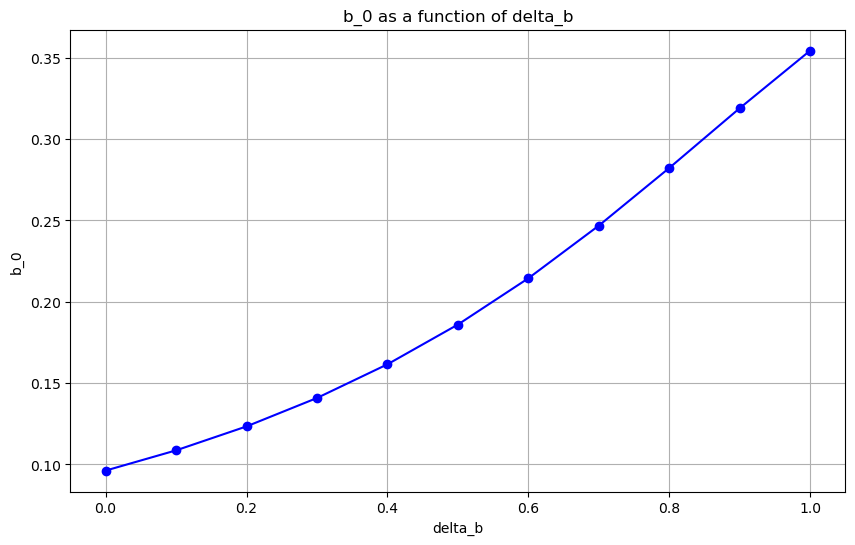

In [239]:
# solve for b_0

def HH_foc_b0(b_0, delta_b, q_0):
    LHS = (2-delta_b)*(y_0 + q_0*b_0 )**(-sigma)
    RHS_1 = (1-delta_b)*(y_l + beta*(1-delta_b)/(1+beta)*b_0 - (1-delta_b)*b_0)**(-sigma)
    RHS_2 = (y_h-b_0/(1+beta))**(-sigma)
    return LHS - RHS_1 - RHS_2

# Initial guess for the root
initial_guess = 0.5

# Vectorized function to solve for the root for each combination of delta_b and q_0
def solve_for_roots(delta_b, q_0, initial_guess):
    # Define a wrapper function for fsolve that only takes b_0 as input
    def wrapper(delta_b, q_0):
        return fsolve(HH_foc_b0, initial_guess, args=(delta_b, q_0))[0]
    
    # Apply the wrapper function to each combination of delta_b and q_0
    b_0 = np.array([wrapper(delta_b, q_0) for delta_b, q_0 in zip(delta_b, q_0)])
    return b_0

# Solve for the roots
b_0 = solve_for_roots(delta_b, q_0, initial_guess)
b_0

# Plot b_0 as a function of delta_b
plt.figure(figsize=(10, 6))
plt.plot(delta_b, b_0, marker='o', linestyle='-', color='b')
plt.xlabel('delta_b')
plt.ylabel('b_0')
plt.title('b_0 as a function of delta_b')
plt.grid(True)
plt.show()

    


In [240]:
# consumption in time 0, c_0

c_0 = y_0 + q_0*b_0
c_0

array([1.07886588, 1.08461336, 1.09102581, 1.09814334, 1.10595673,
       1.11435816, 1.12306545, 1.13152724, 1.13885228, 1.14385359,
       1.14529149])

### Solving Nash Bargaining

In [241]:
# utility function

def utility(c):
    return c**(1-sigma)/(1-sigma)
    #return np.log(c)

utility(0.5)



-2.0

In [242]:
# omega function

def omega(delta_l, theta, b_0):
    HS = ((1+beta)*utility(y_l - (1-delta_l)/(1+beta)*b_0)-utility(y_l)-beta*utility((1-kappa)*y_l))**theta
    FS = (b_0*(1-delta_l))**(1-theta)
    return HS*FS

# grid for delta_l and theta
delta_l = np.linspace(0, 1, 11)
theta_b = np.linspace(0, 1, 11)

#create a meshgrid for delta_l and theta
delta_L, theta_B, B_0 = np.meshgrid(delta_l, theta_b, b_0, indexing='ij')

# matrix for omega
m_omega = omega(delta_L, theta_B, B_0)

# Find the highest value for each combination of theta_B and B_0

max_indices = np.argmax(m_omega, axis=0) 

# Convert indices to corresponding delta_L values
max_delta_L_values = delta_l[max_indices]

print(max_delta_L_values)



[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1 0.2 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.2 0.3 0.  0. ]
 [0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.  0. ]
 [0.  0.  0.  0.  0.2 0.3 0.4 0.4 0.5 0.  0. ]
 [0.  0.  0.2 0.3 0.4 0.4 0.5 0.6 0.6 0.  0. ]
 [0.3 0.3 0.4 0.5 0.6 0.6 0.7 0.7 0.7 0.  0. ]
 [0.6 0.7 0.7 0.7 0.8 0.8 0.8 0.8 0.9 0.  0. ]
 [1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]]


C:\Users\Maude\AppData\Local\Temp\ipykernel_7460\1641505282.py:4: RuntimeWarning: invalid value encountered in power
  HS = ((1+beta)*utility(y_l - (1-delta_l)/(1+beta)*b_0)-utility(y_l)-beta*utility((1-kappa)*y_l))**theta


### Calibration of theta to target b_0/y_0

In [243]:
# rationale expectation

def delta_rational(m_max_delta_L_values, v_delta_l):
    m_delta_l = np.tile(v_delta_l, (len(v_delta_l), 1))
    m_diff=abs(m_max_delta_L_values-m_delta_l)
    min_indices = np.argmin(m_diff, axis=1)
    v_delta_r= v_delta_l[min_indices]
    return v_delta_r, min_indices

delta_rational(max_delta_L_values, delta_l)[0]

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.7, 0.7, 1. ])

In [244]:
# target debt to GDP ratio, b_0/y_0

## open excel file
df = pd.read_excel(os.path.join(PATH_DATA, 'debt_to_GDP - Argentina - IMF.xls'), sheet_name=1)

## Define the years to keep
years_to_keep = [1996, 1997, 1998, 1999, 2000]

## Filter the DataFrame to keep only the rows where Year is in the specified list
df_0 = df[df['Year'].isin(years_to_keep)]
df_0

## Calculate the average of the 'debt_to_GDP' variable
target_b_0_y_0 = df_0['debt_to_GDP'].mean()
target_b_0_y_0


np.float64(37.118)

In [245]:
#b_0/y_0 for each delta in delta_rational
min_indices=delta_rational(max_delta_L_values, delta_l)[1]
b_0[min_indices]

#closest b_0/y_0 to target_b_0_y_0
min_indices_target = np.argmin(abs(b_0[min_indices]-target_b_0_y_0))
b_0[min_indices_target]


np.float64(0.35436948803115353)

In [246]:
# Solution

print(f"The target debt to GDP ratio is {target_b_0_y_0}")
print(f"the calibrated debt to GDP ratio is {b_0[min_indices_target]}")
print(f"The rationale optimal haircut is {delta_l[min_indices_target]}")
print(f"The Nash bargaining power is {theta_b[min_indices_target]}")

The target debt to GDP ratio is 37.118
the calibrated debt to GDP ratio is 0.35436948803115353
The rationale optimal haircut is 1.0
The Nash bargaining power is 1.0
